# Predicting bike rentals
- [Data](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)
- [Solution](https://github.com/dataquestio/solutions/blob/master/Mission213Solution.ipynb)

Columns:
- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)

In this project, we'll try to predict the total number of bikes people rented in a given hour. We'll predict the cnt column using all of the other columns, except for casual and registered (which sum to cnt). To accomplish this, we'll create a few different machine learning models and evaluate their performance.

## Importing and visualizing the data

In [1]:
import pandas as pd
bike_rentals = pd.read_csv('bike_rental_hour.csv', index_col='instant', parse_dates=['dteday'])
bike_rentals.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


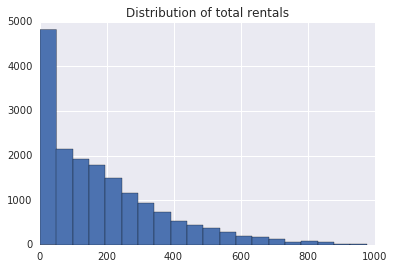

In [175]:
import matplotlib.pyplot as plt
%matplotlib inline
bike_rentals.hist('cnt', bins=20)
plt.title('Distribution of total rentals')

In [3]:
bike_rentals.corr()['cnt']

season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

The following columns are correlated (with absolute value > 0.25) with cnt:
- yr
- hr
- temp
- atemp
- hum

The casual and registered columns have been excluded since they sum to cnt.

## Creating features
We will calculate some features based on domain knowledge. For example, hr is not a very useful measure of the time of day for a ML algorithm, since for example 23 and 0 are very close to one another in reality, but far from each other numerically. We'll create a new feature to split the hr values into morning, afternoon, evening and night.

In [4]:
bike_rentals['hr'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [5]:
def assign_label(hr_numeric):
    if 6 <= hr_numeric < 12:
        return 1
    elif 12 <= hr_numeric < 18:
        return 2
    elif 18 <= hr_numeric < 24:
        return 3
    else:
        return 4
    
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

## Error metric
First, we will look at the cnt column to decide on an error metric to use.

In [6]:
bike_rentals['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

cnt varies widely, between 1 and 977, with a mean of 189.46 and standard deviation of 181.39. Since we are going to be training a regression algorithm, we could consider using MAE or RMSE to evaluate error. We will choose RMSE since this penalises large errors more than the linear MAE.

## Train and test split

In [7]:
def traintest_split(df, frac):
    train = df.sample(frac=frac, random_state=1)
    test = df.loc[~df.index.isin(train.index)]
    return train, test

train, test = traintest_split(bike_rentals, .8)

## Linear regression model
Since many of the columns are highly correlated with cnt, linear regression is one possible candidate for a successful model on this dataset.

We will exclude the casual and registered columns since they are linked with cnt. We will also exclude the dteday. Later, we may need to consider the impact of the high correlation between temp and atemp:

In [8]:
bike_rentals.corr()['temp']['atemp']

0.9876721390396368

Let's create a correlation heatmap to spot any other correlation between potential features.

In [9]:
import seaborn as sns
def heatmap(df):    
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(df, cbar=False,
                     cmap='GnBu', annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        text.set_fontsize('x-large')
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')

    plt.show()

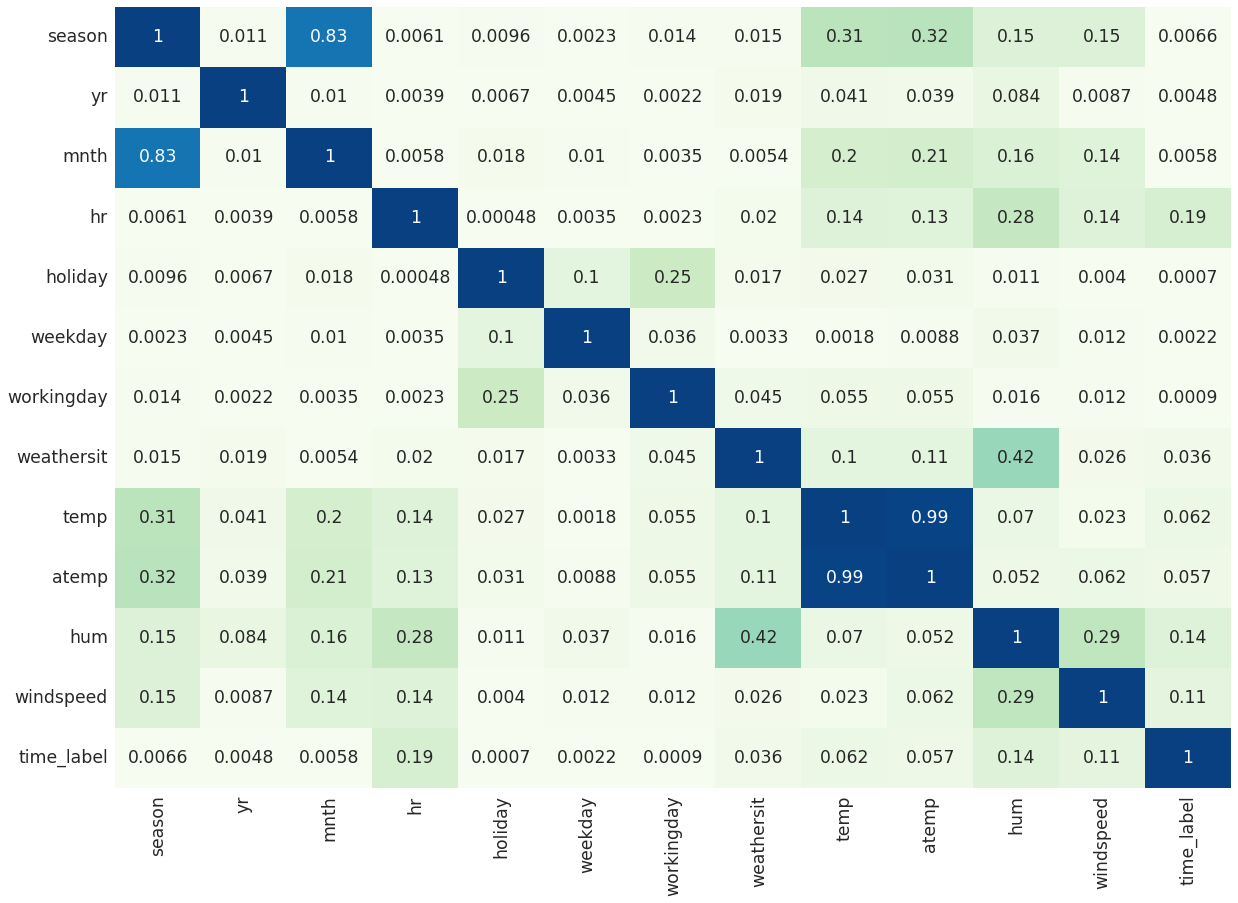

In [10]:
bike_rentals_trim = bike_rentals.drop(labels=['casual', 'registered', 'cnt'], axis=1)
heatmap(bike_rentals_trim.corr().abs())

The following pairs are highly correlated in absolute terms (>.3):
- mnth and season
- temp and atemp
- weathersit and hum
- season and temp
- season and atemp

We will drop mnth, since it isn't well represented on a scale of 1 to 12, whereas season is more fitting. We will also drop temp (because atemp is adjusted for temperature **feel**). We may consider dropping weathersit and/or hum later.

We will now choose our features, dropping the above columns, and additionally:
- dteday (which is a datetime)
- hr (which has been converted to time_label)
- casual and registered (which make up cnt)
- cnt (target)

In [11]:
cols = bike_rentals.columns

In [12]:
cols = cols.drop(['dteday', 'mnth', 'hr', 'temp', 'casual', 'registered', 'cnt'])
cols

Index(['season', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit',
       'atemp', 'hum', 'windspeed', 'time_label'],
      dtype='object')

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
def lin_model(train, test, features, target):
    lr = LinearRegression()
    lr.fit(train[features], train[target])
    predictions = lr.predict(test[features])
    rmse = mean_squared_error(predictions, test[target])**.5
    return rmse

In [14]:
lin_model(train, test, cols, 'cnt')

137.31200570126873

This seems a high RMSE value, and may indicate that linear regression is an unsuitable technique for modelling this dataset. Before we change strategy and try decision trees, let's consider the types of features we've been using.

## Categorical columns
We can see that several of the columns in bike_rentals are in fact categorical:
- season
- yr
- mnth
- hr
- holiday
- weekday
- workingday
- weathersit
- time_label

Let's convert these to categorical data type using `pd.dummies()` and see if our result improves. We'll also drop time_label and season since these are covered by the hr and mnth categories already.

In [15]:
def create_cats(df, cat_cols):
    df_cats = df
    for col in cat_cols:
        df_cats[col] = df[col].astype('category')
        col_dummies = pd.get_dummies(df_cats[col], prefix=col)
        df_cats = pd.concat([df_cats, col_dummies], axis=1)
        del df_cats[col]
    return df_cats
    
cat_cols = ['yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']
bike_rentals_cats = create_cats(bike_rentals, cat_cols)

In [16]:
cols = bike_rentals_cats.columns
cols

Index(['dteday', 'season', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'time_label', 'yr_0', 'yr_1', 'mnth_1', 'mnth_2',
       'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9',
       'mnth_10', 'mnth_11', 'mnth_12', 'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4',
       'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12',
       'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20',
       'hr_21', 'hr_22', 'hr_23', 'holiday_0', 'holiday_1', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'workingday_0', 'workingday_1', 'weathersit_1',
       'weathersit_2', 'weathersit_3', 'weathersit_4'],
      dtype='object')

In [17]:
cols = cols.drop(['dteday', 'season', 'temp', 'casual', 'registered', 'cnt', 'time_label'])

In [18]:
train, test = traintest_split(bike_rentals_cats, .8)
lin_model(train, test, cols, 'cnt')

103.31837563911516

This is a significant improvement in RMSE.

## Decision tree model
First we will re-split the original data into training and test sets; we don't need categorization for the decision tree model as this will happen implicitly.

In [19]:
train, test = traintest_split(bike_rentals, .8)
cols = train.columns
cols

Index(['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'time_label'],
      dtype='object')

In [20]:
cols = cols.drop(['dteday', 'casual', 'registered', 'cnt'])

In [123]:
from sklearn.tree import DecisionTreeRegressor

def tree_model(train, test, features, target, 
               min_samples_leaf=1,
               max_depth=None,
               max_features=None,
               min_samples_split=2,
               **kwargs):
    dt = DecisionTreeRegressor(random_state=1,
                               min_samples_leaf=min_samples_leaf,
                               max_depth=max_depth,
                               max_features=max_features,
                               min_samples_split=min_samples_split)
    dt.fit(train[features], train[target])
    predictions = dt.predict(test[features])
    rmse = mean_squared_error(predictions, test[target])**.5
    return rmse

tree_model(train, test, cols, 'cnt')

57.97565806011068

This is an immediate improvement over the RMSE from our best linear model. Let's try to improve it by changing the parameters of `DecisionTreeRegressor()`. We'll define an outer function which will let us tweak the parameters in `tree_model`:

In [178]:
def tree_parameter(**kwargs):
    return tree_model(train, test, cols, 'cnt', **kwargs)

For example:

In [179]:
tree_parameter(min_samples_leaf=2)

55.59598927568774

In [145]:
rmses = []
values = []
for i in range(1, 51):
    rmses.append(tree_parameter(min_samples_leaf=i))
    values.append(i)
values_index = rmses.index(min(rmses))
values_best = values[values_index]
print('Best min_samples_leaf = {}\nRMSE = {}'.format(values_best, min(rmses)))

Best min_samples_leaf = 7
RMSE = 53.7507355557973


There are small improvements to be had here, with the best `min_samples_leaf` of 7.

In [164]:
rmses = []
values = []
for i in range(1, 51):
    rmses.append(tree_parameter(min_samples_leaf=7, max_depth=i))
    values.append(i)
values_index = rmses.index(min(rmses))
values_best = values[values_index]
print('Best max_depth = {}\nRMSE = {}'.format(values_best, min(rmses)))

Best max_depth = 20
RMSE = 53.70778968755783


This is a very slight improvement so is probably not worth worrying about. Let's try tweaking `max_features`.

In [166]:
rmses = []
values = []
for i in range(1, 14):
    rmses.append(tree_parameter(min_samples_leaf=7, max_depth=20, max_features=i))
    values.append(i)
values_index = rmses.index(min(rmses))
values_best = values[values_index]
print('Best max_features = {}\nRMSE = {}'.format(values_best, min(rmses)))

Best max_features = 13
RMSE = 53.70778968755783


This shows we are best to use all of the available features. Finally let's experiment with `min_samples_split`.

In [169]:
rmses = []
values = []
for i in range(1, 51):
    rmses.append(tree_parameter(min_samples_leaf=7, max_depth=20, max_features=13, min_samples_split=i))
    values.append(i)
values_index = rmses.index(min(rmses))
values_best = values[values_index]
print('Best min_samples_split = {}\nRMSE = {}'.format(values_best, min(rmses)))

Best min_samples_split = 20
RMSE = 53.459254495058644


Again, we have a marginal improvement here. To summarise, we found the best combination of parameters was
- `min_samples_leaf=7`
- `max_depth=20`
- `max_features=None`
- `min_samples_split=20`

Overall, the improvement to RMSE has been quite minor. We have improved it from 58.0 to 53.5. Let's get an idea for how much the model is overfitting. This is a common issue with decision tree algorithms, since they are single and complex. We can have a look at the RMSE of this issue tested on its own training set:

In [63]:
tree_model(train, train, cols, 'cnt', 7, 20, None, 20)

40.81524503527314

This RMSE is substantially lower than that from the test set, which is a sign of overfitting. We will now try to use a random forest to improve accuracy and reduce overfitting.

## Random forest model

In [64]:
from sklearn.ensemble import RandomForestRegressor

In [170]:
def forest_model(train, test, features, target,
               n_estimators=100,
               min_samples_leaf=1,
               max_depth=None,
               max_features=None,
               min_samples_split=2,
               **kwargs):
    dt = RandomForestRegressor(random_state=1, 
                               n_jobs=2, # fit and predict can run together
                               n_estimators=n_estimators,
                               min_samples_leaf=min_samples_leaf,
                               max_depth=max_depth,
                               max_features=max_features,
                               min_samples_split=min_samples_split)
    dt.fit(train[features], train[target])
    predictions = dt.predict(test[features])
    rmse = mean_squared_error(predictions, test[target])**.5
    return rmse

In [173]:
forest_model(train, test, cols, 'cnt')

44.290265127725895

In [180]:
def forest_parameter(**kwargs):
    return forest_model(train, test, cols, 'cnt', **kwargs)

In [210]:
rmses = []
values = []
for i in range(1, 21):
    rmses.append(forest_parameter(min_samples_leaf=i))
    values.append(i)
values_index = rmses.index(min(rmses))
values_best = values[values_index]
print('Best min_samples_leaf = {}\nRMSE = {}'.format(values_best, min(rmses)))

Best min_samples_leaf = 2
RMSE = 44.1511375518945


In [212]:
rmses = []
values = []
for i in range(1, 51):
    rmses.append(forest_parameter(min_samples_leaf=2, max_depth=i))
    values.append(i)
values_index = rmses.index(min(rmses))
values_best = values[values_index]
print('Best max_depth = {}\nRMSE = {}'.format(values_best, min(rmses)))

Best max_depth = 27
RMSE = 44.14171147061926


In [213]:
rmses = []
values = []
for i in range(1, 14):
    rmses.append(forest_parameter(min_samples_leaf=2, max_depth=27, max_features=i))
    values.append(i)
values_index = rmses.index(min(rmses))
values_best = values[values_index]
print('Best max_features = {}\nRMSE = {}'.format(values_best, min(rmses)))

Best max_features = 11
RMSE = 43.32250095337022


In [214]:
rmses = []
values = []
for i in range(1, 51):
    rmses.append(forest_parameter(min_samples_leaf=2, max_depth=27, max_features=11, min_samples_split=i))
    values.append(i)
values_index = rmses.index(min(rmses))
values_best = values[values_index]
print('Best min_samples_split = {}\nRMSE = {}'.format(values_best, min(rmses)))

Best min_samples_split = 1
RMSE = 43.32250095337022


In [215]:
rmses = []
values = []
for i in range(1, 202, 20):
    rmses.append(forest_parameter(min_samples_leaf=2, max_depth=27, max_features=11, min_samples_split=1, n_estimators=i))
    values.append(i)
values_index = rmses.index(min(rmses))
values_best = values[values_index]
print('Best n_estimators = {}\nRMSE = {}'.format(values_best, min(rmses)))

Best n_estimators = 121
RMSE = 43.25013230535258


All of these parameter tweaks have produced very marginal gains, but we've demonstrated an improvement in RMSE from the first linear model (RMSE = 137), to this forest model (RMSE = 43).